In [4]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report

# Path to the training and testing directories
train_dir = r'D:\thesis\code\bangla_Handwritten_data\Train'
test_dir = r'D:\thesis\code\bangla_Handwritten_data\Test'

# Count the number of classes based on the number of subfolders in the training directory
num_classes = len(os.listdir(train_dir))

# Data Preprocessing
train_datagen = ImageDataGenerator(
    rescale=1./255,
    # Other preprocessing techniques like rotation, zoom, etc. can be added here
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(50, 50),  # Resizing to 50x50 dimensions
    color_mode='grayscale',  # Convert images to grayscale
    batch_size=32,
    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(50, 50),  # Resizing to 50x50 dimensions
    color_mode='grayscale',  # Convert images to grayscale
    batch_size=32,
    class_mode='categorical')

# Model Architecture (ResNet-50)
def identity_block(input_tensor, kernel_size, filters, stage, block):
    filters1, filters2, filters3 = filters
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    x = layers.Conv2D(filters1, (1, 1), name=conv_name_base + '2a')(input_tensor)
    x = layers.BatchNormalization(name=bn_name_base + '2a')(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters2, kernel_size, padding='same', name=conv_name_base + '2b')(x)
    x = layers.BatchNormalization(name=bn_name_base + '2b')(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters3, (1, 1), name=conv_name_base + '2c')(x)
    x = layers.BatchNormalization(name=bn_name_base + '2c')(x)

    x = layers.add([x, input_tensor])
    x = layers.Activation('relu')(x)
    return x

def conv_block(input_tensor, kernel_size, filters, stage, block, strides=(2, 2)):
    filters1, filters2, filters3 = filters
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    x = layers.Conv2D(filters1, (1, 1), strides=strides, name=conv_name_base + '2a')(input_tensor)
    x = layers.BatchNormalization(name=bn_name_base + '2a')(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters2, kernel_size, padding='same', name=conv_name_base + '2b')(x)
    x = layers.BatchNormalization(name=bn_name_base + '2b')(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters3, (1, 1), name=conv_name_base + '2c')(x)
    x = layers.BatchNormalization(name=bn_name_base + '2c')(x)

    shortcut = layers.Conv2D(filters3, (1, 1), strides=strides, name=conv_name_base + '1')(input_tensor)
    shortcut = layers.BatchNormalization(name=bn_name_base + '1')(shortcut)

    x = layers.add([x, shortcut])
    x = layers.Activation('relu')(x)
    return x

inputs = layers.Input(shape=(50, 50, 1))

x = layers.ZeroPadding2D((3, 3))(inputs)
x = layers.Conv2D(64, (7, 7), strides=(2, 2), name='conv1')(x)
x = layers.BatchNormalization(name='bn_conv1')(x)
x = layers.Activation('relu')(x)
x = layers.MaxPooling2D((3, 3), strides=(2, 2))(x)

x = conv_block(x, 3, [64, 64, 256], stage=2, block='a', strides=(1, 1))
x = identity_block(x, 3, [64, 64, 256], stage=2, block='b')
x = identity_block(x, 3, [64, 64, 256], stage=2, block='c')

x = conv_block(x, 3, [128, 128, 512], stage=3, block='a')
x = identity_block(x, 3, [128, 128, 512], stage=3, block='b')
x = identity_block(x, 3, [128, 128, 512], stage=3, block='c')
x = identity_block(x, 3, [128, 128, 512], stage=3, block='d')

x = conv_block(x, 3, [256, 256, 1024], stage=4, block='a')
x = identity_block(x, 3, [256, 256, 1024], stage=4, block='b')
x = identity_block(x, 3, [256, 256, 1024], stage=4, block='c')
x = identity_block(x, 3, [256, 256, 1024], stage=4, block='d')
x = identity_block(x, 3, [256, 256, 1024], stage=4, block='e')
x = identity_block(x, 3, [256, 256, 1024], stage=4, block='f')

x = conv_block(x, 3, [512, 512, 2048], stage=5, block='a')
x = identity_block(x, 3, [512, 512, 2048], stage=5, block='b')
x = identity_block(x, 3, [512, 512, 2048], stage=5, block='c')

x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(num_classes, activation='softmax', name='fc' + str(num_classes))(x)

model = models.Model(inputs, x, name='resnet50')

# Compile the Model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Training
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples/train_generator.batch_size,
    epochs=10,  # Train for 10 epochs
    validation_data=validation_generator,
    validation_steps=validation_generator.samples/validation_generator.batch_size
)

# Evaluation
y_pred = model.predict(validation_generator)
y_true = validation_generator.classes

# Convert predictions to class labels
y_pred_labels = np.argmax(y_pred, axis=1)

# Compute precision, recall, and F1-score
report = classification_report(y_true, y_pred_labels)
print(report)

# Additional Evaluation (Accuracy)
test_loss, test_acc = model.evaluate(validation_generator)
print('Test accuracy:', test_acc)

Found 12000 images belonging to 50 classes.
Found 3000 images belonging to 50 classes.
Epoch 1/10
375/375 [==============================] - 188s 456ms/step - loss: 2.9499 - accuracy: 0.3663 - val_loss: 5.5739 - val_accuracy: 0.0790
Epoch 2/10
375/375 [==============================] - 164s 437ms/step - loss: 0.9075 - accuracy: 0.7729 - val_loss: 1.6079 - val_accuracy: 0.7833
Epoch 3/10
375/375 [==============================] - 165s 440ms/step - loss: 0.5878 - accuracy: 0.8473 - val_loss: 0.5288 - val_accuracy: 0.8417
Epoch 4/10
375/375 [==============================] - 207s 552ms/step - loss: 0.5366 - accuracy: 0.8687 - val_loss: 1.1508 - val_accuracy: 0.8243
Epoch 5/10
375/375 [==============================] - 206s 549ms/step - loss: 0.6315 - accuracy: 0.8290 - val_loss: 1.5307 - val_accuracy: 0.8397
Epoch 6/10
375/375 [==============================] - 210s 560ms/step - loss: 0.4322 - accuracy: 0.8937 - val_loss: 0.7447 - val_accuracy: 0.7900
Epoch 7/10
375/375 [=================

In [5]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report

# Path to the training and testing directories
train_dir = r'D:\thesis\code\bangla_Handwritten_data\Train'
test_dir = r'D:\thesis\code\bangla_Handwritten_data\Test'

# Count the number of classes based on the number of subfolders in the training directory
num_classes = len(os.listdir(train_dir))

# Data Preprocessing
train_datagen = ImageDataGenerator(
    rescale=1./255,
    # Other preprocessing techniques like rotation, zoom, etc. can be added here
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(50, 50),  # Resizing to 50x50 dimensions
    color_mode='grayscale',  # Convert images to grayscale
    batch_size=32,
    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(50, 50),  # Resizing to 50x50 dimensions
    color_mode='grayscale',  # Convert images to grayscale
    batch_size=32,
    class_mode='categorical')

# Model Architecture (ResNet-50)
def identity_block(input_tensor, kernel_size, filters, stage, block):
    filters1, filters2, filters3 = filters
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    x = layers.Conv2D(filters1, (1, 1), name=conv_name_base + '2a')(input_tensor)
    x = layers.BatchNormalization(name=bn_name_base + '2a')(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters2, kernel_size, padding='same', name=conv_name_base + '2b')(x)
    x = layers.BatchNormalization(name=bn_name_base + '2b')(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters3, (1, 1), name=conv_name_base + '2c')(x)
    x = layers.BatchNormalization(name=bn_name_base + '2c')(x)

    x = layers.add([x, input_tensor])
    x = layers.Activation('relu')(x)
    return x

def conv_block(input_tensor, kernel_size, filters, stage, block, strides=(2, 2)):
    filters1, filters2, filters3 = filters
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    x = layers.Conv2D(filters1, (1, 1), strides=strides, name=conv_name_base + '2a')(input_tensor)
    x = layers.BatchNormalization(name=bn_name_base + '2a')(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters2, kernel_size, padding='same', name=conv_name_base + '2b')(x)
    x = layers.BatchNormalization(name=bn_name_base + '2b')(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters3, (1, 1), name=conv_name_base + '2c')(x)
    x = layers.BatchNormalization(name=bn_name_base + '2c')(x)

    shortcut = layers.Conv2D(filters3, (1, 1), strides=strides, name=conv_name_base + '1')(input_tensor)
    shortcut = layers.BatchNormalization(name=bn_name_base + '1')(shortcut)

    x = layers.add([x, shortcut])
    x = layers.Activation('relu')(x)
    return x

inputs = layers.Input(shape=(50, 50, 1))

x = layers.ZeroPadding2D((3, 3))(inputs)
x = layers.Conv2D(64, (7, 7), strides=(2, 2), name='conv1')(x)
x = layers.BatchNormalization(name='bn_conv1')(x)
x = layers.Activation('relu')(x)
x = layers.MaxPooling2D((3, 3), strides=(2, 2))(x)

x = conv_block(x, 3, [64, 64, 256], stage=2, block='a', strides=(1, 1))
x = identity_block(x, 3, [64, 64, 256], stage=2, block='b')
x = identity_block(x, 3, [64, 64, 256], stage=2, block='c')

x = conv_block(x, 3, [128, 128, 512], stage=3, block='a')
x = identity_block(x, 3, [128, 128, 512], stage=3, block='b')
x = identity_block(x, 3, [128, 128, 512], stage=3, block='c')
x = identity_block(x, 3, [128, 128, 512], stage=3, block='d')

x = conv_block(x, 3, [256, 256, 1024], stage=4, block='a')
x = identity_block(x, 3, [256, 256, 1024], stage=4, block='b')
x = identity_block(x, 3, [256, 256, 1024], stage=4, block='c')
x = identity_block(x, 3, [256, 256, 1024], stage=4, block='d')
x = identity_block(x, 3, [256, 256, 1024], stage=4, block='e')
x = identity_block(x, 3, [256, 256, 1024], stage=4, block='f')

x = conv_block(x, 3, [512, 512, 2048], stage=5, block='a')
x = identity_block(x, 3, [512, 512, 2048], stage=5, block='b')
x = identity_block(x, 3, [512, 512, 2048], stage=5, block='c')

x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(num_classes, activation='softmax', name='fc' + str(num_classes))(x)

model = models.Model(inputs, x, name='resnet50')

# Compile the Model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Training
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples/train_generator.batch_size,
    epochs=20,  # Train for 20 epochs
    validation_data=validation_generator,
    validation_steps=validation_generator.samples/validation_generator.batch_size
)

# Evaluation
y_pred = model.predict(validation_generator)
y_true = validation_generator.classes

# Convert predictions to class labels
y_pred_labels = np.argmax(y_pred, axis=1)

# Compute precision, recall, and F1-score
report = classification_report(y_true, y_pred_labels)
print(report)

# Additional Evaluation (Accuracy)
test_loss, test_acc = model.evaluate(validation_generator)
print('Test accuracy:', test_acc)

Found 12000 images belonging to 50 classes.
Found 3000 images belonging to 50 classes.
Epoch 1/20
375/375 [==============================] - 355s 802ms/step - loss: 3.5164 - accuracy: 0.2334 - val_loss: 6.0184 - val_accuracy: 0.0760
Epoch 2/20
375/375 [==============================] - 404s 1s/step - loss: 1.3205 - accuracy: 0.6326 - val_loss: 0.7661 - val_accuracy: 0.7577
Epoch 3/20
375/375 [==============================] - 304s 810ms/step - loss: 0.7377 - accuracy: 0.7941 - val_loss: 1.5074 - val_accuracy: 0.7330
Epoch 4/20
375/375 [==============================] - 283s 754ms/step - loss: 0.6240 - accuracy: 0.8337 - val_loss: 1.8639 - val_accuracy: 0.8413
Epoch 5/20
375/375 [==============================] - 279s 745ms/step - loss: 0.4351 - accuracy: 0.8883 - val_loss: 2.0581 - val_accuracy: 0.8547
Epoch 6/20
375/375 [==============================] - 276s 737ms/step - loss: 0.3875 - accuracy: 0.8981 - val_loss: 0.3440 - val_accuracy: 0.9013
Epoch 7/20
375/375 [====================

In [6]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report

# Path to the training and testing directories
train_dir = r'D:\thesis\code\bangla_Handwritten_data\Train'
test_dir = r'D:\thesis\code\bangla_Handwritten_data\Test'

# Count the number of classes based on the number of subfolders in the training directory
num_classes = len(os.listdir(train_dir))

# Data Preprocessing
train_datagen = ImageDataGenerator(
    rescale=1./255,
    # Other preprocessing techniques like rotation, zoom, etc. can be added here
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(50, 50),  # Resizing to 50x50 dimensions
    color_mode='grayscale',  # Convert images to grayscale
    batch_size=32,
    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(50, 50),  # Resizing to 50x50 dimensions
    color_mode='grayscale',  # Convert images to grayscale
    batch_size=32,
    class_mode='categorical')

# Model Architecture (ResNet-50)
def identity_block(input_tensor, kernel_size, filters, stage, block):
    filters1, filters2, filters3 = filters
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    x = layers.Conv2D(filters1, (1, 1), name=conv_name_base + '2a')(input_tensor)
    x = layers.BatchNormalization(name=bn_name_base + '2a')(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters2, kernel_size, padding='same', name=conv_name_base + '2b')(x)
    x = layers.BatchNormalization(name=bn_name_base + '2b')(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters3, (1, 1), name=conv_name_base + '2c')(x)
    x = layers.BatchNormalization(name=bn_name_base + '2c')(x)

    x = layers.add([x, input_tensor])
    x = layers.Activation('relu')(x)
    return x

def conv_block(input_tensor, kernel_size, filters, stage, block, strides=(2, 2)):
    filters1, filters2, filters3 = filters
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    x = layers.Conv2D(filters1, (1, 1), strides=strides, name=conv_name_base + '2a')(input_tensor)
    x = layers.BatchNormalization(name=bn_name_base + '2a')(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters2, kernel_size, padding='same', name=conv_name_base + '2b')(x)
    x = layers.BatchNormalization(name=bn_name_base + '2b')(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters3, (1, 1), name=conv_name_base + '2c')(x)
    x = layers.BatchNormalization(name=bn_name_base + '2c')(x)

    shortcut = layers.Conv2D(filters3, (1, 1), strides=strides, name=conv_name_base + '1')(input_tensor)
    shortcut = layers.BatchNormalization(name=bn_name_base + '1')(shortcut)

    x = layers.add([x, shortcut])
    x = layers.Activation('relu')(x)
    return x

inputs = layers.Input(shape=(50, 50, 1))

x = layers.ZeroPadding2D((3, 3))(inputs)
x = layers.Conv2D(64, (7, 7), strides=(2, 2), name='conv1')(x)
x = layers.BatchNormalization(name='bn_conv1')(x)
x = layers.Activation('relu')(x)
x = layers.MaxPooling2D((3, 3), strides=(2, 2))(x)

x = conv_block(x, 3, [64, 64, 256], stage=2, block='a', strides=(1, 1))
x = identity_block(x, 3, [64, 64, 256], stage=2, block='b')
x = identity_block(x, 3, [64, 64, 256], stage=2, block='c')

x = conv_block(x, 3, [128, 128, 512], stage=3, block='a')
x = identity_block(x, 3, [128, 128, 512], stage=3, block='b')
x = identity_block(x, 3, [128, 128, 512], stage=3, block='c')
x = identity_block(x, 3, [128, 128, 512], stage=3, block='d')

x = conv_block(x, 3, [256, 256, 1024], stage=4, block='a')
x = identity_block(x, 3, [256, 256, 1024], stage=4, block='b')
x = identity_block(x, 3, [256, 256, 1024], stage=4, block='c')
x = identity_block(x, 3, [256, 256, 1024], stage=4, block='d')
x = identity_block(x, 3, [256, 256, 1024], stage=4, block='e')
x = identity_block(x, 3, [256, 256, 1024], stage=4, block='f')

x = conv_block(x, 3, [512, 512, 2048], stage=5, block='a')
x = identity_block(x, 3, [512, 512, 2048], stage=5, block='b')
x = identity_block(x, 3, [512, 512, 2048], stage=5, block='c')

x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(num_classes, activation='softmax', name='fc' + str(num_classes))(x)

model = models.Model(inputs, x, name='resnet50')

# Compile the Model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Training
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples/train_generator.batch_size,
    epochs=16,  # Train for 16 epochs
    validation_data=validation_generator,
    validation_steps=validation_generator.samples/validation_generator.batch_size
)

# Evaluation
y_pred = model.predict(validation_generator)
y_true = validation_generator.classes

# Convert predictions to class labels
y_pred_labels = np.argmax(y_pred, axis=1)

# Compute precision, recall, and F1-score
report = classification_report(y_true, y_pred_labels)
print(report)

# Additional Evaluation (Accuracy)
test_loss, test_acc = model.evaluate(validation_generator)
print('Test accuracy:', test_acc)

Found 12000 images belonging to 50 classes.
Found 3000 images belonging to 50 classes.
Epoch 1/16
375/375 [==============================] - 343s 767ms/step - loss: 3.1908 - accuracy: 0.3146 - val_loss: 6.1879 - val_accuracy: 0.0527
Epoch 2/16
375/375 [==============================] - 288s 769ms/step - loss: 1.1424 - accuracy: 0.6995 - val_loss: 2.3621 - val_accuracy: 0.7177
Epoch 3/16
375/375 [==============================] - 388s 1s/step - loss: 0.6967 - accuracy: 0.8121 - val_loss: 0.7950 - val_accuracy: 0.7580
Epoch 4/16
375/375 [==============================] - 387s 1s/step - loss: 0.5809 - accuracy: 0.8377 - val_loss: 0.5999 - val_accuracy: 0.8340
Epoch 5/16
375/375 [==============================] - 388s 1s/step - loss: 0.4869 - accuracy: 0.8676 - val_loss: 0.7142 - val_accuracy: 0.8070
Epoch 6/16
375/375 [==============================] - 391s 1s/step - loss: 0.4188 - accuracy: 0.8852 - val_loss: 0.5527 - val_accuracy: 0.8927
Epoch 7/16
375/375 [=============================

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report

# Path to the training and testing directories
train_dir = r'D:\thesis\code\bangla_Handwritten_data\Train'
test_dir = r'D:\thesis\code\bangla_Handwritten_data\Test'

# Count the number of classes based on the number of subfolders in the training directory
num_classes = len(os.listdir(train_dir))

# Data Preprocessing
train_datagen = ImageDataGenerator(
    rescale=1./255,
    # Other preprocessing techniques like rotation, zoom, etc. can be added here
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(50, 50),  # Resizing to 50x50 dimensions
    color_mode='grayscale',  # Convert images to grayscale
    batch_size=32,
    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(50, 50),  # Resizing to 50x50 dimensions
    color_mode='grayscale',  # Convert images to grayscale
    batch_size=32,
    class_mode='categorical')

# Model Architecture (ResNet-50)
def identity_block(input_tensor, kernel_size, filters, stage, block):
    filters1, filters2, filters3 = filters
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    x = layers.Conv2D(filters1, (1, 1), name=conv_name_base + '2a')(input_tensor)
    x = layers.BatchNormalization(name=bn_name_base + '2a')(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters2, kernel_size, padding='same', name=conv_name_base + '2b')(x)
    x = layers.BatchNormalization(name=bn_name_base + '2b')(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters3, (1, 1), name=conv_name_base + '2c')(x)
    x = layers.BatchNormalization(name=bn_name_base + '2c')(x)

    x = layers.add([x, input_tensor])
    x = layers.Activation('relu')(x)
    return x

def conv_block(input_tensor, kernel_size, filters, stage, block, strides=(2, 2)):
    filters1, filters2, filters3 = filters
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    x = layers.Conv2D(filters1, (1, 1), strides=strides, name=conv_name_base + '2a')(input_tensor)
    x = layers.BatchNormalization(name=bn_name_base + '2a')(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters2, kernel_size, padding='same', name=conv_name_base + '2b')(x)
    x = layers.BatchNormalization(name=bn_name_base + '2b')(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters3, (1, 1), name=conv_name_base + '2c')(x)
    x = layers.BatchNormalization(name=bn_name_base + '2c')(x)

    shortcut = layers.Conv2D(filters3, (1, 1), strides=strides, name=conv_name_base + '1')(input_tensor)
    shortcut = layers.BatchNormalization(name=bn_name_base + '1')(shortcut)

    x = layers.add([x, shortcut])
    x = layers.Activation('relu')(x)
    return x

inputs = layers.Input(shape=(50, 50, 1))

x = layers.ZeroPadding2D((3, 3))(inputs)
x = layers.Conv2D(64, (7, 7), strides=(2, 2), name='conv1')(x)
x = layers.BatchNormalization(name='bn_conv1')(x)
x = layers.Activation('relu')(x)
x = layers.MaxPooling2D((3, 3), strides=(2, 2))(x)

x = conv_block(x, 3, [64, 64, 256], stage=2, block='a', strides=(1, 1))
x = identity_block(x, 3, [64, 64, 256], stage=2, block='b')
x = identity_block(x, 3, [64, 64, 256], stage=2, block='c')

x = conv_block(x, 3, [128, 128, 512], stage=3, block='a')
x = identity_block(x, 3, [128, 128, 512], stage=3, block='b')
x = identity_block(x, 3, [128, 128, 512], stage=3, block='c')
x = identity_block(x, 3, [128, 128, 512], stage=3, block='d')

x = conv_block(x, 3, [256, 256, 1024], stage=4, block='a')
x = identity_block(x, 3, [256, 256, 1024], stage=4, block='b')
x = identity_block(x, 3, [256, 256, 1024], stage=4, block='c')
x = identity_block(x, 3, [256, 256, 1024], stage=4, block='d')
x = identity_block(x, 3, [256, 256, 1024], stage=4, block='e')
x = identity_block(x, 3, [256, 256, 1024], stage=4, block='f')

x = conv_block(x, 3, [512, 512, 2048], stage=5, block='a')
x = identity_block(x, 3, [512, 512, 2048], stage=5, block='b')
x = identity_block(x, 3, [512, 512, 2048], stage=5, block='c')

x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(num_classes, activation='softmax', name='fc' + str(num_classes))(x)

model = models.Model(inputs, x, name='resnet50')

# Compile the Model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Training
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples/train_generator.batch_size,
    epochs=16,  # Train for 16 epochs
    validation_data=validation_generator,
    validation_steps=validation_generator.samples/validation_generator.batch_size
)

# Evaluation
y_pred = model.predict(validation_generator)
y_true = validation_generator.classes

# Convert predictions to class labels
y_pred_labels = np.argmax(y_pred, axis=1)

# Compute precision, recall, and F1-score
report = classification_report(y_true, y_pred_labels)
print(report)

# Calculate test accuracy
test_loss, test_acc = model.evaluate(test_generator)
print('Test accuracy:', test_acc)

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred_labels)
plt.figure(figsize=(15, 6))
plt.imshow(conf_matrix, cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(class_labels))
plt.xticks(tick_marks, class_labels, rotation=45)
plt.yticks(tick_marks, class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

# Accuracy Curves
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Curves')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Loss Curves
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


Found 12000 images belonging to 50 classes.
Found 3000 images belonging to 50 classes.



Epoch 1/16


375/375 [==============================] - 323s 690ms/step - loss: 2.9456 - accuracy: 0.3546 - val_loss: 6.2245 - val_accuracy: 0.0660
Epoch 2/16
375/375 [==============================] - 254s 676ms/step - loss: 1.0355 - accuracy: 0.7322 - val_loss: 0.9424 - val_accuracy: 0.7813
Epoch 3/16
375/375 [==============================] - 252s 672ms/step - loss: 0.5466 - accuracy: 0.8481 - val_loss: 0.6503 - val_accuracy: 0.8177
Epoch 4/16
375/375 [==============================] - 252s 673ms/step - loss: 0.3505 - accuracy: 0.9015 - val_loss: 0.3522 - val_accuracy: 0.8957
Epoch 5/16
375/375 [==============================] - 253s 676ms/step - loss: 0.2703 - accuracy: 0.9245 - val_loss: 0.7065 - val_accuracy: 0.8063
Epoch 6/16
375/375 [==============================] - 256s 684ms/step - loss: 0.2922 - accuracy: 0.9202 - val_loss: 0.6057 - val_accuracy: 0.8347
Epoch 7/16
375/375 [===========


Found 12000 images belonging to 50 classes.
Found 3000 images belonging to 50 classes.



Epoch 1/30


375/375 [==============================] - 175s 421ms/step - loss: 3.0442 - accuracy: 0.3535 - val_loss: 5.5094 - val_accuracy: 0.1017
Epoch 2/30
375/375 [==============================] - 157s 420ms/step - loss: 1.2019 - accuracy: 0.6925 - val_loss: 7.8872 - val_accuracy: 0.3133
Epoch 3/30
375/375 [==============================] - 160s 426ms/step - loss: 0.6449 - accuracy: 0.8099 - val_loss: 0.5133 - val_accuracy: 0.8580
Epoch 4/30
375/375 [==============================] - 162s 432ms/step - loss: 0.3458 - accuracy: 0.8970 - val_loss: 0.5715 - val_accuracy: 0.8713
Epoch 5/30
375/375 [==============================] - 164s 438ms/step - loss: 0.2544 - accuracy: 0.9227 - val_loss: 0.5599 - val_accuracy: 0.8747
Epoch 6/30
375/375 [==============================] - 162s 432ms/step - loss: 0.2079 - accuracy: 0.9367 - val_loss: 0.6053 - val_accuracy: 0.8340
Epoch 7/30
375/375 [===========

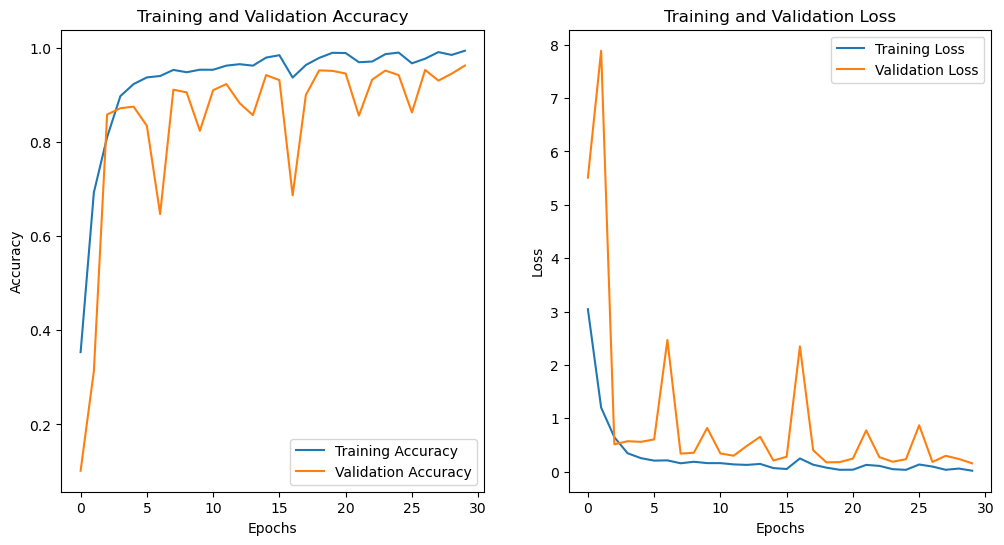

94/94 [==============================] - 8s 73ms/step
              precision    recall  f1-score   support

           0       0.02      0.02      0.02        60
           1       0.02      0.02      0.02        60
           2       0.00      0.00      0.00        60
           3       0.00      0.00      0.00        60
           4       0.02      0.02      0.02        60
           5       0.02      0.02      0.02        60
           6       0.00      0.00      0.00        60
           7       0.00      0.00      0.00        60
           8       0.03      0.03      0.03        60
           9       0.04      0.03      0.03        60
          10       0.00      0.00      0.00        60
          11       0.03      0.03      0.03        60
          12       0.00      0.00      0.00        60
          13       0.03      0.03      0.03        60
          14       0.00      0.00      0.00        60
          15       0.02      0.02      0.02        60
          16       0.02    

In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

# Path to the training and testing directories
train_dir = r'D:\thesis\code\bangla_Handwritten_data\Train'
test_dir = r'D:\thesis\code\bangla_Handwritten_data\Test'

# Count the number of classes based on the number of subfolders in the training directory
num_classes = len(os.listdir(train_dir))

# Data Preprocessing
train_datagen = ImageDataGenerator(
    rescale=1./255,
    # Other preprocessing techniques like rotation, zoom, etc. can be added here
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(50, 50),  # Resizing to 50x50 dimensions
    color_mode='grayscale',  # Convert images to grayscale
    batch_size=32,
    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(50, 50),  # Resizing to 50x50 dimensions
    color_mode='grayscale',  # Convert images to grayscale
    batch_size=32,
    class_mode='categorical')

# Model Architecture (ResNet-50)
# Define your model here
def identity_block(input_tensor, kernel_size, filters, stage, block):
    filters1, filters2, filters3 = filters
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    x = layers.Conv2D(filters1, (1, 1), name=conv_name_base + '2a')(input_tensor)
    x = layers.BatchNormalization(name=bn_name_base + '2a')(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters2, kernel_size, padding='same', name=conv_name_base + '2b')(x)
    x = layers.BatchNormalization(name=bn_name_base + '2b')(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters3, (1, 1), name=conv_name_base + '2c')(x)
    x = layers.BatchNormalization(name=bn_name_base + '2c')(x)

    x = layers.add([x, input_tensor])
    x = layers.Activation('relu')(x)
    return x

def conv_block(input_tensor, kernel_size, filters, stage, block, strides=(2, 2)):
    filters1, filters2, filters3 = filters
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    x = layers.Conv2D(filters1, (1, 1), strides=strides, name=conv_name_base + '2a')(input_tensor)
    x = layers.BatchNormalization(name=bn_name_base + '2a')(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters2, kernel_size, padding='same', name=conv_name_base + '2b')(x)
    x = layers.BatchNormalization(name=bn_name_base + '2b')(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters3, (1, 1), name=conv_name_base + '2c')(x)
    x = layers.BatchNormalization(name=bn_name_base + '2c')(x)

    shortcut = layers.Conv2D(filters3, (1, 1), strides=strides, name=conv_name_base + '1')(input_tensor)
    shortcut = layers.BatchNormalization(name=bn_name_base + '1')(shortcut)

    x = layers.add([x, shortcut])
    x = layers.Activation('relu')(x)
    return x

inputs = layers.Input(shape=(50, 50, 1))

x = layers.ZeroPadding2D((3, 3))(inputs)
x = layers.Conv2D(64, (7, 7), strides=(2, 2), name='conv1')(x)
x = layers.BatchNormalization(name='bn_conv1')(x)
x = layers.Activation('relu')(x)
x = layers.MaxPooling2D((3, 3), strides=(2, 2))(x)

x = conv_block(x, 3, [64, 64, 256], stage=2, block='a', strides=(1, 1))
x = identity_block(x, 3, [64, 64, 256], stage=2, block='b')
x = identity_block(x, 3, [64, 64, 256], stage=2, block='c')

x = conv_block(x, 3, [128, 128, 512], stage=3, block='a')
x = identity_block(x, 3, [128, 128, 512], stage=3, block='b')
x = identity_block(x, 3, [128, 128, 512], stage=3, block='c')
x = identity_block(x, 3, [128, 128, 512], stage=3, block='d')

x = conv_block(x, 3, [256, 256, 1024], stage=4, block='a')
x = identity_block(x, 3, [256, 256, 1024], stage=4, block='b')
x = identity_block(x, 3, [256, 256, 1024], stage=4, block='c')
x = identity_block(x, 3, [256, 256, 1024], stage=4, block='d')
x = identity_block(x, 3, [256, 256, 1024], stage=4, block='e')
x = identity_block(x, 3, [256, 256, 1024], stage=4, block='f')

x = conv_block(x, 3, [512, 512, 2048], stage=5, block='a')
x = identity_block(x, 3, [512, 512, 2048], stage=5, block='b')
x = identity_block(x, 3, [512, 512, 2048], stage=5, block='c')

x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(num_classes, activation='softmax', name='fc' + str(num_classes))(x)

model = models.Model(inputs, x, name='resnet50')

# Compile the Model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Training
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples/train_generator.batch_size,
    epochs=30,  # Train for 30 epochs
    validation_data=validation_generator,
    validation_steps=validation_generator.samples/validation_generator.batch_size
)

# Plotting Accuracy and Loss Curves
plt.figure(figsize=(12, 6))

# Accuracy Curves
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss Curves
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# Evaluation
y_pred = model.predict(validation_generator)
y_true = validation_generator.classes

# Convert predictions to class labels
y_pred_labels = np.argmax(y_pred, axis=1)

# Compute precision, recall, and F1-score
report = classification_report(y_true, y_pred_labels)
print(report)

# Confusion Matrix
conf_mat = confusion_matrix(y_true, y_pred_labels)
print("Confusion Matrix:")
print(conf_mat)

# Additional Evaluation (Accuracy)
test_loss, test_acc = model.evaluate(validation_generator)
print('Test accuracy:', test_acc)


Found 12000 images belonging to 50 classes.
Found 3000 images belonging to 50 classes.
Epoch 1/30
375/375 [==============================] - 171s 412ms/step - loss: 2.9700 - accuracy: 0.3532 - val_loss: 6.3108 - val_accuracy: 0.0707
Epoch 2/30
375/375 [==============================] - 156s 415ms/step - loss: 1.0807 - accuracy: 0.7203 - val_loss: 4.4087 - val_accuracy: 0.6897
Epoch 3/30
375/375 [==============================] - 156s 417ms/step - loss: 0.6456 - accuracy: 0.8194 - val_loss: 4.6863 - val_accuracy: 0.5860
Epoch 4/30
375/375 [==============================] - 157s 418ms/step - loss: 0.4886 - accuracy: 0.8583 - val_loss: 2.9084 - val_accuracy: 0.8147
Epoch 5/30
375/375 [==============================] - 156s 416ms/step - loss: 0.2938 - accuracy: 0.9153 - val_loss: 18.2223 - val_accuracy: 0.5863
Epoch 6/30
375/375 [==============================] - 156s 416ms/step - loss: 0.3265 - accuracy: 0.9077 - val_loss: 0.9612 - val_accuracy: 0.8330
Epoch 7/30
375/375 [================

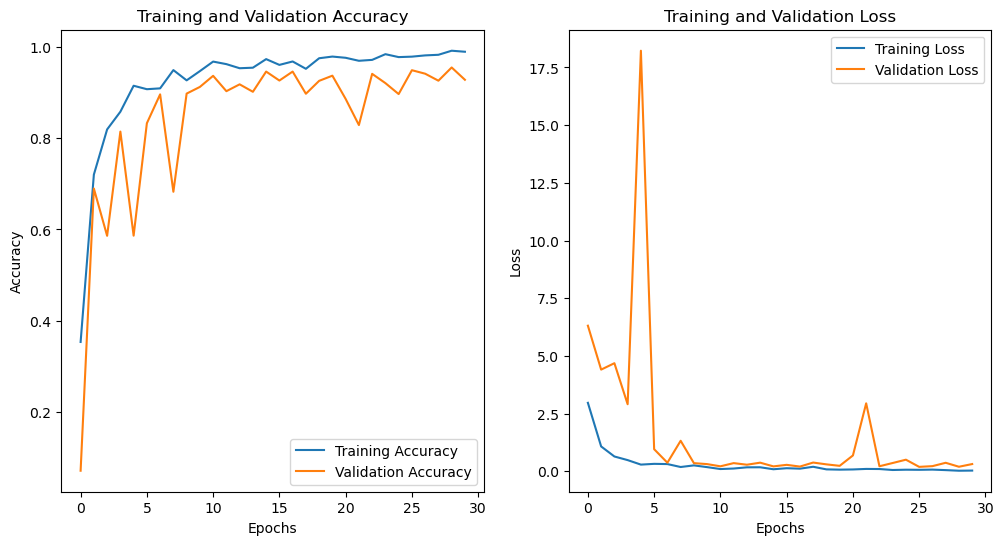

94/94 [==============================] - 7s 69ms/step
              precision    recall  f1-score   support

         172       0.02      0.02      0.02        60
         173       0.02      0.02      0.02        60
         174       0.00      0.00      0.00        60
         175       0.02      0.02      0.02        60
         176       0.00      0.00      0.00        60
         177       0.00      0.00      0.00        60
         178       0.07      0.07      0.07        60
         179       0.02      0.02      0.02        60
         180       0.00      0.00      0.00        60
         181       0.00      0.00      0.00        60
         182       0.02      0.02      0.02        60
         183       0.02      0.02      0.02        60
         184       0.02      0.02      0.02        60
         185       0.03      0.03      0.03        60
         186       0.02      0.02      0.02        60
         187       0.04      0.03      0.03        60
         188       0.03    

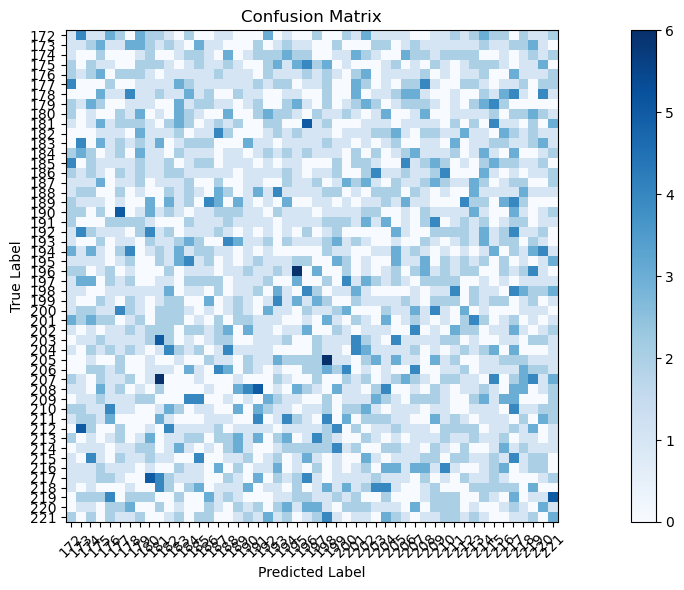

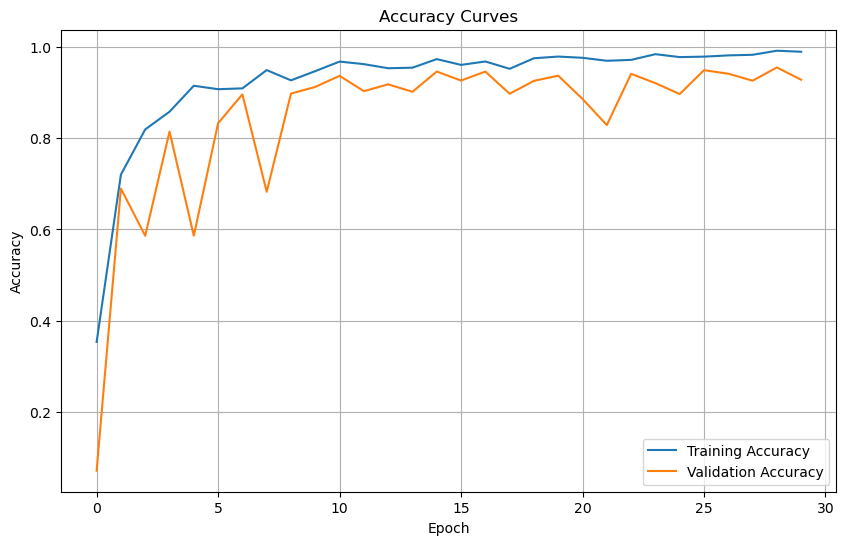

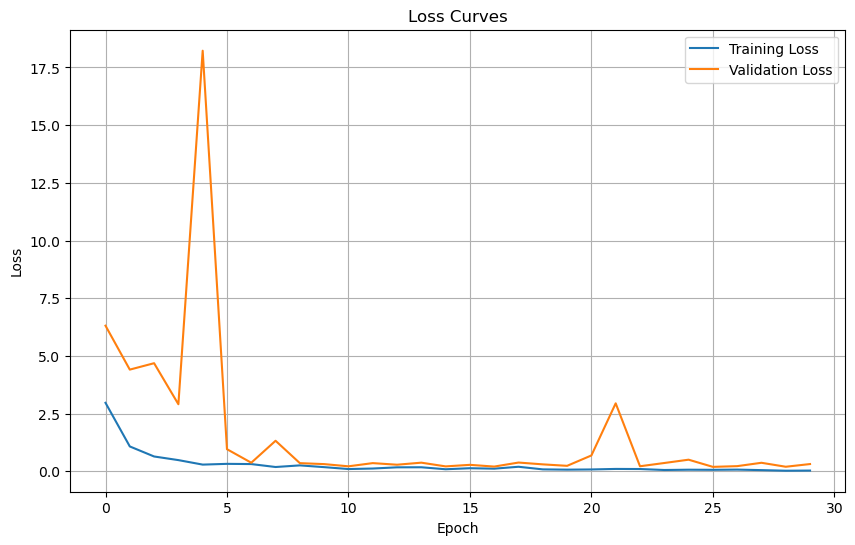

In [2]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

# Path to the training and testing directories
train_dir = r'D:\thesis\code\bangla_Handwritten_data\Train'
test_dir = r'D:\thesis\code\bangla_Handwritten_data\Test'

# Count the number of classes based on the number of subfolders in the training directory
num_classes = len(os.listdir(train_dir))

# Data Preprocessing
train_datagen = ImageDataGenerator(
    rescale=1./255,
    # Other preprocessing techniques like rotation, zoom, etc. can be added here
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(50, 50),  # Resizing to 50x50 dimensions
    color_mode='grayscale',  # Convert images to grayscale
    batch_size=32,
    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(50, 50),  # Resizing to 50x50 dimensions
    color_mode='grayscale',  # Convert images to grayscale
    batch_size=32,
    class_mode='categorical')

# Model Architecture (ResNet-50)
# Define your model here
def identity_block(input_tensor, kernel_size, filters, stage, block):
    filters1, filters2, filters3 = filters
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    x = layers.Conv2D(filters1, (1, 1), name=conv_name_base + '2a')(input_tensor)
    x = layers.BatchNormalization(name=bn_name_base + '2a')(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters2, kernel_size, padding='same', name=conv_name_base + '2b')(x)
    x = layers.BatchNormalization(name=bn_name_base + '2b')(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters3, (1, 1), name=conv_name_base + '2c')(x)
    x = layers.BatchNormalization(name=bn_name_base + '2c')(x)

    x = layers.add([x, input_tensor])
    x = layers.Activation('relu')(x)
    return x

def conv_block(input_tensor, kernel_size, filters, stage, block, strides=(2, 2)):
    filters1, filters2, filters3 = filters
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    x = layers.Conv2D(filters1, (1, 1), strides=strides, name=conv_name_base + '2a')(input_tensor)
    x = layers.BatchNormalization(name=bn_name_base + '2a')(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters2, kernel_size, padding='same', name=conv_name_base + '2b')(x)
    x = layers.BatchNormalization(name=bn_name_base + '2b')(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters3, (1, 1), name=conv_name_base + '2c')(x)
    x = layers.BatchNormalization(name=bn_name_base + '2c')(x)

    shortcut = layers.Conv2D(filters3, (1, 1), strides=strides, name=conv_name_base + '1')(input_tensor)
    shortcut = layers.BatchNormalization(name=bn_name_base + '1')(shortcut)

    x = layers.add([x, shortcut])
    x = layers.Activation('relu')(x)
    return x

inputs = layers.Input(shape=(50, 50, 1))

x = layers.ZeroPadding2D((3, 3))(inputs)
x = layers.Conv2D(64, (7, 7), strides=(2, 2), name='conv1')(x)
x = layers.BatchNormalization(name='bn_conv1')(x)
x = layers.Activation('relu')(x)
x = layers.MaxPooling2D((3, 3), strides=(2, 2))(x)

x = conv_block(x, 3, [64, 64, 256], stage=2, block='a', strides=(1, 1))
x = identity_block(x, 3, [64, 64, 256], stage=2, block='b')
x = identity_block(x, 3, [64, 64, 256], stage=2, block='c')

x = conv_block(x, 3, [128, 128, 512], stage=3, block='a')
x = identity_block(x, 3, [128, 128, 512], stage=3, block='b')
x = identity_block(x, 3, [128, 128, 512], stage=3, block='c')
x = identity_block(x, 3, [128, 128, 512], stage=3, block='d')

x = conv_block(x, 3, [256, 256, 1024], stage=4, block='a')
x = identity_block(x, 3, [256, 256, 1024], stage=4, block='b')
x = identity_block(x, 3, [256, 256, 1024], stage=4, block='c')
x = identity_block(x, 3, [256, 256, 1024], stage=4, block='d')
x = identity_block(x, 3, [256, 256, 1024], stage=4, block='e')
x = identity_block(x, 3, [256, 256, 1024], stage=4, block='f')

x = conv_block(x, 3, [512, 512, 2048], stage=5, block='a')
x = identity_block(x, 3, [512, 512, 2048], stage=5, block='b')
x = identity_block(x, 3, [512, 512, 2048], stage=5, block='c')

x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(num_classes, activation='softmax', name='fc' + str(num_classes))(x)

model = models.Model(inputs, x, name='resnet50')

# Compile the Model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Training
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples/train_generator.batch_size,
    epochs=30,  # Train for 30 epochs
    validation_data=validation_generator,
    validation_steps=validation_generator.samples/validation_generator.batch_size
)

# Plotting Accuracy and Loss Curves
plt.figure(figsize=(12, 6))

# Accuracy Curves
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss Curves
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# Evaluation
y_pred = model.predict(validation_generator)
y_true = validation_generator.classes

# Convert predictions to class labels
y_pred_labels = np.argmax(y_pred, axis=1)

# Compute precision, recall, and F1-score
class_labels = list(validation_generator.class_indices.keys())
report = classification_report(y_true, y_pred_labels, target_names=class_labels)
print(report)

# Calculate test accuracy
test_loss, test_acc = model.evaluate(validation_generator)
print('Test accuracy:', test_acc)

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred_labels)
plt.figure(figsize=(15, 6))
plt.imshow(conf_matrix, cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(class_labels))
plt.xticks(tick_marks, class_labels, rotation=45)
plt.yticks(tick_marks, class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

# Accuracy Curves
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Curves')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Loss Curves
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()
